In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/victor/catkin_ws/src/ai4hri/simulated data.csv")

costumer = df.iloc[:,14]
costumer_clean = costumer.dropna()

shopkeeper = df.iloc[:,16]
shopkeeper_clean = shopkeeper.dropna()

costumer_list = costumer_clean.values.tolist()
shopkeeper_list = shopkeeper_clean.values.tolist()

print(shopkeeper_clean)
print(len(shopkeeper_list))

1                       good afternoon how can I help today
2         Yes we do have this nikon camera it's a point ...
3         This camera is very easy to use. Just choose a...
4         Because it's fully automatic sometimes gets a ...
5                thanks for your time have a good afternoon
                                ...                        
124170             can I ask what sort of pictures you take
124171    let me explain the layout of the store, the ni...
124172    it also has 18 different modes where you can t...
124173    this camera comes in purple pink black silver ...
124174                                      Thanks for time
Name: SHOPKEEPER_SPEECH, Length: 95430, dtype: object
95430


In [3]:
import openai
import os

openai.organization = os.environ['OPENAI_ORG_ID']
openai.api_key = os.environ["OPENAI_API_KEY"]

model = "text-embedding-ada-002"

res = openai.Embedding.create( input = shopkeeper_list[:100], engine=model)

In [4]:
import numpy

list=[]
for vec in res["data"]:
    list.append(vec["embedding"])

arr = numpy.asarray(list)
print(arr.shape)


(100, 1536)


/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (96) found smaller than n_clusters (97). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (96) found smaller than n_clusters (98). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/victor/.local/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:339: ConvergenceWarning: Number of distinct clusters (96) found smaller than n_clusters (99). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)


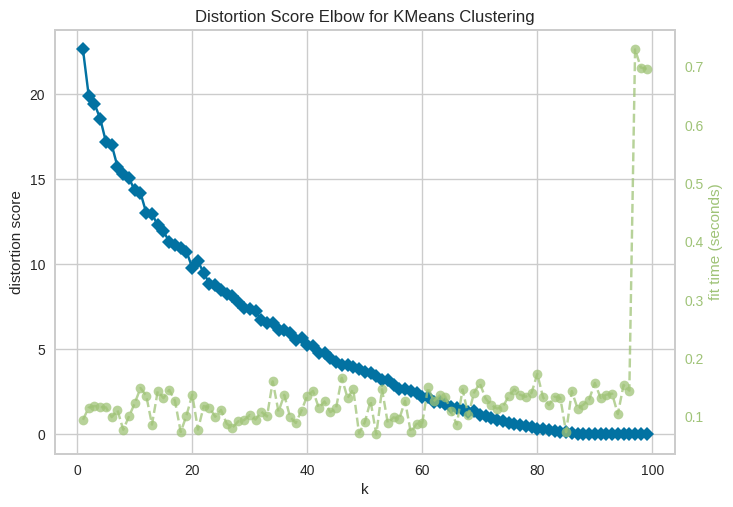

In [5]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init="auto")
visualizer = KElbowVisualizer(model, k=(1,100), locate_elbow=False)

visualizer.fit(arr)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [6]:
n_clusters = 45
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(arr)
np.save("kmeans_model.npy", kmeans)
y = kmeans.predict(arr)

print(y)

[ 3 19  6 15 14 24 19 20 26 27  0 18 29 41 25 36  8 37  1 22 30 11  2  1
  9 17 40  2 30 23 21  5 39  7 42  8 37  2 35 34  6 43 11 17 10 12  5 16
 16 14  3 13 44 34  9  3  4 15  0 32  1  5  1  9 18  1 31 27 12 14  3  6
 10 35 34 33 10 30 34 20 10  6  6 36 10 40 17 11 35 31 28 38  5  2 19 14
  3  8 19 20]


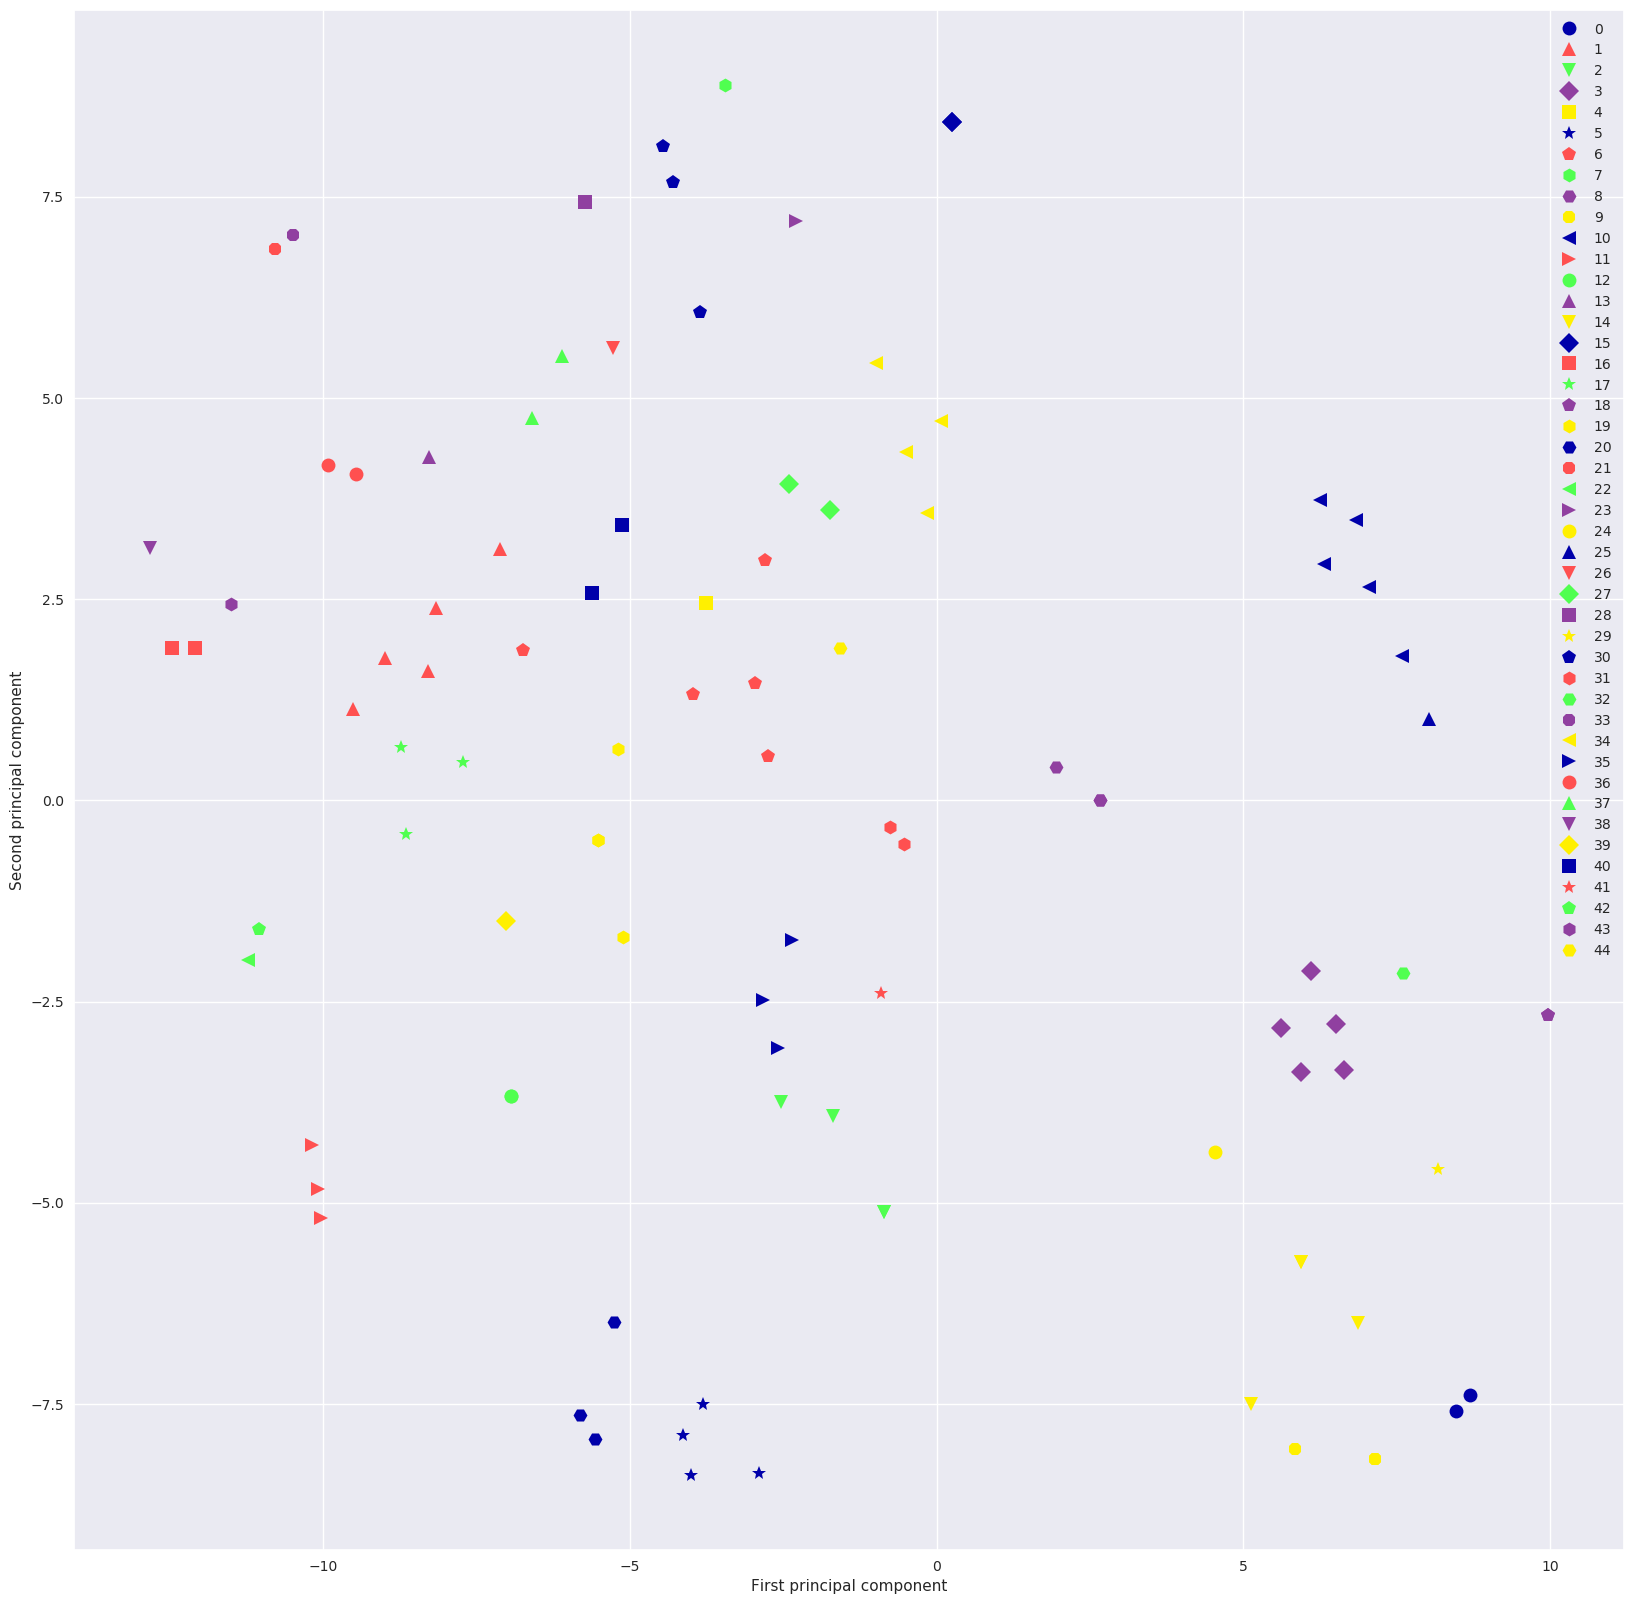

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plot_scatter as ps

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(arr)

n_classes=np.arange(0, 50, 1).tolist()
s = []
for x in n_classes:
    s.append(str(x))

plt.figure(figsize=(20, 20))
sns.set_style('darkgrid')
ps.discrete_scatter(tsne_result[:, 0], tsne_result[:, 1], y)
plt.legend(s, loc="best")
#plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()





In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

cluster_X = np.where(y == 17)[0]

vector_list = []
for j in cluster_X:
    print(shopkeeper_list[j])
    print(arr[j])
    vector_list.append(arr[j].tolist())
    print("----------------------")

print("Cosine similarity between a given utterance and the rest of the cluster:")
cluster_sum_list = []
for i in range(len(vector_list)):
    total_sum=0
    for j in range(len(vector_list)):
        total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
    cluster_sum_list.append(total_sum)
    print(cluster_sum_list[i])

print("----------------------")
cluster_sum_array = numpy.array(cluster_sum_list)
typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
print("Typical utterance inside the cluster: " + typical_utt)

kw_model = KeyBERT(model='all-mpnet-base-v2')
keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)

print("Assigned keywords to the utterance: " + str(keywords))





/home/victor/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You can see the autofocus is very responsive  it can follow the moving characters within the frame quite well
[-0.02758814  0.01393776 -0.01853578 ... -0.00932667 -0.02066498
 -0.02756202]
----------------------
It's got 179 autofocus point so you can pinpoint anything almost anywhere in your picture and follow it around and keep it in focus quite well its very responsive
[-0.02705778  0.02680632 -0.01782897 ... -0.00030569 -0.01572922
 -0.02256911]
----------------------
it's got a lot of autofocus points on it so it can follow anything that's moving in the frame to make sure that it stays in crisp focus, it's got a lot of preset modes well so you can tell what environment you are shooting in
[-0.01042737  0.01382875 -0.01885858 ... -0.01060467 -0.01917376
 -0.02135379]
----------------------
Cosine similarity between a given utterance and the rest of the cluster:
[[2.80843846]]
[[2.83609984]]
[[2.81953268]]
----------------------
Typical utterance inside the cluster: It's got 179 aut

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT

keyword_dict = {}
utterance_dict = {}

for z in range(n_clusters):
    cluster_X = np.where(y == z)[0]
    vector_list = []
    for j in cluster_X:
        vector_list.append(arr[j].tolist())

    cluster_sum_list = []
    for i in range(len(vector_list)):
        total_sum=0
        for j in range(len(vector_list)):
            total_sum += cosine_similarity([vector_list[i]],[vector_list[j]])
        cluster_sum_list.append(total_sum)

    cluster_sum_array = numpy.array(cluster_sum_list)
    typical_utt = shopkeeper_list[cluster_X[np.argmax(cluster_sum_list)]]
    print("Cluster " + str(z) + ": " + typical_utt)

    kw_model = KeyBERT(model='all-mpnet-base-v2')
    keywords = kw_model.extract_keywords(typical_utt, keyphrase_ngram_range=(1,1), use_maxsum=False, top_n=10)
    print("Keywords: " + str(keywords))
    print("---------------")

    utterance_dict[z] = typical_utt
    keyword_dict[z] = keywords

np.save("utterance_dict.npy", utterance_dict)
np.save("keyword_dict.npy", keyword_dict)

Cluster 0: thank you for visiting our store
Keywords: [('store', 0.4575), ('visiting', 0.4154), ('thank', 0.3059)]
---------------
Cluster 1: This is the Sony, it has 179 autofocus points which will help you get great sports photos
Keywords: [('autofocus', 0.467), ('sony', 0.4123), ('sports', 0.3305), ('photos', 0.2261), ('points', 0.2114), ('179', 0.1577), ('help', 0.0324), ('great', -0.0487)]
---------------
Cluster 2: there is 13 different effect
Keywords: [('effect', 0.5845), ('13', 0.299), ('different', 0.2457)]
---------------
Cluster 3: good afternoon how can I help
Keywords: [('help', 0.5724), ('afternoon', 0.3307), ('good', 0.1214)]
---------------
Cluster 4: if he like to take pictures his family and friends, this is point and shoot fully automatically, we can go through all the menus with you here to make sure it's absolutely certain, it's simple operation
Keywords: [('pictures', 0.2541), ('automatically', 0.253), ('family', 0.1636), ('simple', 0.1597), ('menus', 0.1462), ('

In [10]:
openai.organization = os.environ.get("OPENAI_ORG_ID")
openai.api_key = os.environ.get("OPENAI_API_KEY")

model = "text-embedding-ada-002"

res2 = openai.Embedding.create( input = ["this camera is available in black, white and silver"], engine=model)

list2=[]
for vec in res2["data"]:
    list2.append(vec["embedding"])

arr2 = numpy.asarray(list2)

y = kmeans.predict(arr2)
print("Cluster:" + str(y[0]))
print("typical utterance:" + str(utterance_dict[y[0]]))
print("Keywords:" + str(keyword_dict[y[0]]))

Cluster:5
Keywords:It comes in 3 different colors white silver and black
Keywords:[('silver', 0.4333), ('black', 0.3786), ('colors', 0.363), ('white', 0.331), ('comes', 0.1953), ('different', 0.1356)]


In [104]:
# PENDIENTE:
# Hacer cluster de todo el dataset de Malcolm. 
# Incluir las 2 utterances a la hora de identificar los topics de la conversación
# Crear tabla SQL con horarios shopkeeper para saber a quien introducir conocimiento en la Ontologia
# Crear Ontologia
# Meter todo en un docker para poder ejecutarlo en cualquier sistema operativo?